In [431]:
import matplotlib.pyplot as plt
import datetime as dt
import time
import pandas as pd
import numpy as np
import json
from pandas.io.json import json_normalize
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import seaborn as sns
import folium
import geopandas as gpd

In [241]:
#Describe Dataset here
filename = 'data\zillow\MortgageRateConventionalFixed.csv'
mortgage_rates_src = pd.read_csv(filename)

#Describe Dataset here
filename = 'data\zillow\Affordability_Wide_2019Q2_Public.csv'
affordability_index_src = pd.read_csv(filename,encoding='latin-1',skipinitialspace=True)

#Describe Dataset here
filename = 'data\zillow\Affordability_Income_2018Q4.csv'
affordability_income_src = pd.read_csv(filename,encoding='latin-1',skipinitialspace=True)

#Median Rental Price - Single Family Residence
filename = 'data\zillow\City_MedianRentalPrice_Sfr.csv'
median_rental_price_sfr_src = pd.read_csv(filename,skipinitialspace=True)

#Median Rental Price Per Square Foot - Single Family Residence
filename = 'data\zillow\City_MedianRentalPricePerSqft_Sfr.csv'
median_rental_price_sfr_sqft_src = pd.read_csv(filename,skipinitialspace=True)

#Median Rental Price - Multi-Family Residence
filename = 'data\zillow\City_MedianRentalPrice_Mfr5Plus.csv'
median_rental_price_mfr_src = pd.read_csv(filename,skipinitialspace=True)

#Median Rental Price Per Square Foot - Multi-Family Residence
filename = 'data\zillow\City_MedianRentalPricePerSqft_Mfr5Plus.csv'
median_rental_price_mfr_sqft_src = pd.read_csv(filename,skipinitialspace=True)

#Rental Index Per Square Foot - All Homes
filename = 'data\zillow\City_ZriPerSqft_AllHomes.csv'
rental_index_all_sqft_src = pd.read_csv(filename,encoding='latin-1',skipinitialspace=True)

#Median Value - All Homes
filename = 'data\zillow\City_Zhvi_AllHomes.csv'
median_value_all_src = pd.read_csv(filename,encoding='latin-1',skipinitialspace=True)

#Median Value Per Square Foot - All Homes
filename = 'data\zillow\City_MedianValuePerSqft_AllHomes.csv'
median_value_all_sqft_src = pd.read_csv(filename,encoding='latin-1',skipinitialspace=True)

#Count of Home Sales
filename = 'data\zillow\Sale_Counts_City.csv'
sales_count_src = pd.read_csv(filename,encoding='latin-1',skipinitialspace=True)

#rental vacancy Rate - 10 years quarterly
filename = 'data/rental_vacancy_rate_10_yrs.csv'
rental_vacancy_rate_src = pd.read_csv(filename,encoding='latin-1',skipinitialspace=True)

#Unemployment Rate - 20 years 
filename = 'data/unemployment_rate_20_years.csv'
unemployment_rate_src = pd.read_csv(filename,encoding='latin-1',skipinitialspace=True)

#Unemployment Rate - by state 
filename = 'data/unemployment_rate_by_state.csv'
unemployment_rate_state_src = pd.read_csv(filename,encoding='latin-1',skipinitialspace=True)

#Monthly Listing all homes - city
filename = 'data/zillow/MonthlyListings_NSA_AllHomes_City.csv'
monthly_listings_allhomes_city_src = pd.read_csv(filename,encoding='latin-1',skipinitialspace=True)

#Sale Counts - city
filename = 'data/zillow/Sale_Counts_City.csv'
monthly_sale_counts_city_src = pd.read_csv(filename,encoding='latin-1',skipinitialspace=True)

#Sale prices - city
filename = 'data/zillow/Sale_Prices_City.csv'
monthly_sale_prices_city_src = pd.read_csv(filename,encoding='latin-1',skipinitialspace=True)

housing_crash_date = ['2008','12']
state_geo = 'data/folium/us-states.json'


In [3]:
#build state name / id xref
with open(state_geo) as json_file:
    state_geo_df = json.load(json_file)
state_geo_xref = json_normalize(state_geo_df['features']).filter(items=['id','properties.name'])
state_geo_xref = state_geo_xref.rename(columns={'id':'State','properties.name':'StateName'})#.set_index('State')
state_geo_xref.head()

,State,StateName
0,AL,Alabama
1,AK,Alaska
2,AZ,Arizona
3,AR,Arkansas
4,CA,California


In [4]:
# create geodataframe and add centroids
gdf = gpd.GeoDataFrame.from_features(state_geo_df)
gdf['centroid_lon'] = gdf['geometry'].centroid.x
gdf['centroid_lat'] = gdf['geometry'].centroid.y
gdf.crs = {'init' :'epsg:4326'}
gdf.head()

,geometry,name,centroid_lon,centroid_lat
0,"POLYGON ((-87.359296 35.00118, -85.606675 34.9...",Alabama,-86.827783,32.789907
1,"(POLYGON ((-131.602021 55.117982, -131.569159 ...",Alaska,-152.373738,64.227768
2,"POLYGON ((-109.042503 37.000263, -109.04798 31...",Arizona,-111.663296,34.293393
3,"POLYGON ((-94.473842 36.501861, -90.152536 36....",Arkansas,-92.440920,34.898249
4,"POLYGON ((-123.233256 42.006186, -122.378853 4...",California,-119.614389,37.253895


In [5]:
#merge w/ data points
median_rental_price_mfr_state_year = median_rental_price_mfr_src.copy()
median_rental_price_mfr_state_year = median_rental_price_mfr_state_year.merge(state_geo_xref, left_on='State', right_on='State')
median_rental_price_mfr_state_year.set_index(['RegionName','State','Metro','CountyName','SizeRank'],inplace=True)
median_rental_price_mfr_state_year.columns = pd.MultiIndex.from_tuples([tuple(c.split('-'))for c in median_rental_price_mfr_state_year.columns],names=['Year','Month'])
median_rental_price_mfr_state_year = median_rental_price_mfr_state_year.stack().reset_index().groupby(['State','StateName']).median().drop(columns='SizeRank')
gdf_income_tax = gdf.merge(median_rental_price_mfr_state_year.reset_index(),how='right', left_on='name', right_on='StateName')
gdf_income_tax = gdf_income_tax.fillna(method='bfill',axis=1).dropna(how='all',axis=1)
gdf_income_tax.head()

,geometry,name,centroid_lon,centroid_lat,State,StateName,2010,2011,2012,2013,2014,2015,2016,2017,2018
0,"POLYGON ((-87.359296 35.00118, -85.606675 34.9...",Alabama,-86.8278,32.7899,AL,Alabama,880,880,819.5,902.5,847,794,760,888.5,973
1,"(POLYGON ((-131.602021 55.117982, -131.569159 ...",Alaska,-152.374,64.2278,AK,Alaska,1500,1500,1500,1500,1450,1300,1312.5,1150,1225
2,"POLYGON ((-109.042503 37.000263, -109.04798 31...",Arizona,-111.663,34.2934,AZ,Arizona,850,725,760,795,800,917,935,1088.5,1148
3,"POLYGON ((-94.473842 36.501861, -90.152536 36....",Arkansas,-92.4409,34.8982,AR,Arkansas,700,700,760,701.5,750,735,722.5,693.5,728
4,"POLYGON ((-123.233256 42.006186, -122.378853 4...",California,-119.614,37.2539,CA,California,1648.5,1454.75,1525,1642.5,1756,1822.75,1850,1972.25,2029.5


In [316]:
#unemployment_rate_state = unemployment_rate_state_src.set_index('State').merge(state_geo_xref,left_index=True,right_index=True)

years = [col for col in gdf_income_tax.columns if col not in ['geometry','name','centroid_lon','centroid_lat','State','StateName']]



#render the map
map_name = 'Median Rent ($)'
#m = folium.Map(location=[np.median(gdf_income_tax['centroid_lat'].tolist()), np.median(gdf_income_tax['centroid_lon'].tolist())], tiles='Stamen Toner', zoom_start=12)

m = folium.Map([43, -100], zoom_start=4)

for year in years:
    year = folium.Choropleth(
    geo_data=state_geo,
    data=gdf_income_tax,
    columns=['State', year],
    key_on='feature.id',
    fill_color='YlGn',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name= f'{year} - {map_name}',
    overlay=True,
    name = year
    )
    m.add_child(year)
    for lat, lon, val, name in zip(gdf_income_tax['centroid_lat'].tolist(), gdf_income_tax['centroid_lon'].tolist(), gdf_income_tax['2010'].tolist(), gdf_income_tax['State'].tolist()):
        folium.Marker(lat,lon, popup=val).add_to(m)
        
    
'''
    # add markers with basic information
    fg = folium.FeatureGroup(name='District Info')
    for lat, lon, val, name in zip(gdf_income_tax['centroid_lat'].tolist(), gdf_income_tax['centroid_lon'].tolist(), gdf_income_tax[year].tolist(), gdf_income_tax['State'].tolist()):
        html = f"""
        <h2>{name}<\h2><br>
        <h4>Income Tax Per Capita: {int(round(val,0))} HUF <\h4>
        """
        fg.add_child(folium.Marker(location=[lat, lon], popup=html))
'''

folium.LayerControl().add_to(m)
m.save(map_name+'.html')

m

TypeError: __init__() got multiple values for argument 'popup'

In [312]:
#unemployment_rate_state = unemployment_rate_state_src.set_index('State').merge(state_geo_xref,left_index=True,right_index=True)

years = [col for col in gdf_income_tax.columns if col not in ['geometry','name','centroid_lon','centroid_lat','State','StateName']]



#render the map
map_name = 'Median Rent ($)'
#m = folium.Map(location=[np.median(gdf_income_tax['centroid_lat'].tolist()), np.median(gdf_income_tax['centroid_lon'].tolist())], tiles='Stamen Toner', zoom_start=12)

m = folium.Map([43, -100], zoom_start=4)

for year in years:
    
    # add markers with basic information
    fg = folium.FeatureGroup(name=f'{year}-Rent',
    folium.Choropleth(
    geo_data=state_geo,
    data=gdf_income_tax,
    columns=['State', year],
    key_on='feature.id',
    fill_color='YlGn',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name= f'{year} - {map_name}',
    #overlay=True,
    name = year
    ).add_to(m)
    #m.add_child(yr)
    for lat, lon, val, name in zip(gdf_income_tax['centroid_lat'].tolist(), gdf_income_tax['centroid_lon'].tolist(), gdf_income_tax[year].tolist(), gdf_income_tax['name'].tolist()):
        html = f"""
        <h2>{name}<\h2><br>
        <h4>Median Rent ({year}): {int(round(val,0))} HUF <\h4>
        """
        fg.add_child(folium.Marker(location=[lat, lon], popup=html))
    m.add_child(fg)
                             )

folium.LayerControl().add_to(m)
m.save(map_name+'.html')

m

SyntaxError: invalid syntax (<ipython-input-312-8c7b997be7a6>, line 30)

In [314]:
#unemployment_rate_state = unemployment_rate_state_src.set_index('State').merge(state_geo_xref,left_index=True,right_index=True)

years = [col for col in gdf_income_tax.columns if col not in ['geometry','name','centroid_lon','centroid_lat','State','StateName']]



#render the map
map_name = 'Median Rent ($)'
#m = folium.Map(location=[np.median(gdf_income_tax['centroid_lat'].tolist()), np.median(gdf_income_tax['centroid_lon'].tolist())], tiles='Stamen Toner', zoom_start=12)

m = folium.Map([43, -100], zoom_start=4)

for year in years:
    yr = folium.Choropleth(
    geo_data=state_geo,
    data=gdf_income_tax,
    columns=['State', year],
    key_on='feature.id',
    fill_color='YlGn',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name= f'{year} - {map_name}',
    #overlay=True,
    name = year
    )
    m.add_child(yr)
    # add markers with basic information
    fg = folium.FeatureGroup(name=f'{year}-Rent')
    for lat, lon, val, name in zip(gdf_income_tax['centroid_lat'].tolist(), gdf_income_tax['centroid_lon'].tolist(), gdf_income_tax[year].tolist(), gdf_income_tax['name'].tolist()):
        html = f"""
        <h2>{name}<\h2><br>
        <h4>Median Rent ({year}): {int(round(val,0))} HUF <\h4>
        """
        fg.add_child(folium.Marker(location=[lat, lon], popup=html))
    m.add_child(fg)

folium.LayerControl().add_to(m)
m.save(map_name+'.html')

m

In [313]:
#unemployment_rate_state = unemployment_rate_state_src.set_index('State').merge(state_geo_xref,left_index=True,right_index=True)
from folium.plugins import TimeSliderChoropleth
years = [col for col in gdf_income_tax.columns if col not in ['geometry','name','centroid_lon','centroid_lat','State','StateName']]



#render the map
map_name = 'Median Rent ($)'
#m = folium.Map(location=[np.median(gdf_income_tax['centroid_lat'].tolist()), np.median(gdf_income_tax['centroid_lon'].tolist())], tiles='Stamen Toner', zoom_start=12)

m = folium.Map([43, -100], zoom_start=4)

for year in years:
    yr = folium.plugins.TimeSliderChoropleth(
    #geo_data=state_geo,
    data=gdf_income_tax,
    #columns=['State', year],
    #key_on='feature.id',
    #fill_color='YlGn',
    #fill_opacity=0.7,
    #line_opacity=0.2,
    #legend_name= f'{year} - {map_name}',
    #overlay=True,
    name = year
    )
    m.add_child(yr)
    # add markers with basic information
    fg = folium.FeatureGroup(name=f'{year}-Rent')
    for lat, lon, val, name in zip(gdf_income_tax['centroid_lat'].tolist(), gdf_income_tax['centroid_lon'].tolist(), gdf_income_tax[year].tolist(), gdf_income_tax['name'].tolist()):
        html = f"""
        <h2>{name}<\h2><br>
        <h4>Median Rent ({year}): {int(round(val,0))} HUF <\h4>
        """
        fg.add_child(folium.Marker(location=[lat, lon], popup=html))
    m.add_child(fg)

folium.LayerControl().add_to(m)
m.save(map_name+'.html')

m

TypeError: __init__() missing 1 required positional argument: 'styledict'

# Annual Metrics Collection

# median rental price per sqft

In [76]:
median_rental_price_sfr_sqft = median_rental_price_sfr_sqft_src.copy()
median_rental_price_sfr_sqft.drop(columns=['State','RegionName','Metro','CountyName','SizeRank'],inplace=True)
median_rental_price_sfr_sqft.columns = pd.MultiIndex.from_tuples([tuple(c.split('-'))for c in median_rental_price_sfr_sqft.columns],names=['Year','Month'])
median_rental_price_sfr_sqft = pd.DataFrame(median_rental_price_sfr_sqft.median()).reset_index()
median_rental_price_sfr_sqft.columns=['Year','Month','RentalRateSqFt']
median_rental_price_sfr_sqft['Year'] = median_rental_price_sfr_sqft['Year'].astype(int)
median_rental_price_sfr_sqft['Month'] = median_rental_price_sfr_sqft['Month'].astype(int)
median_rental_price_sfr_sqft

,Year,Month,RentalRateSqFt
0,2010,1,0.670390
1,2010,2,0.776057
2,2010,3,0.786121
3,2010,4,0.784661
4,2010,5,0.785475
...,...,...,...
111,2019,4,1.053218
112,2019,5,1.056812
113,2019,6,1.060215
114,2019,7,1.066499


## median rental price

In [77]:
median_rental_price_sfr = median_rental_price_sfr_src.copy()
median_rental_price_sfr.drop(columns=['State','RegionName','Metro','CountyName','SizeRank'],inplace=True)
median_rental_price_sfr.columns = pd.MultiIndex.from_tuples([tuple(c.split('-'))for c in median_rental_price_sfr.columns],names=['Year','Month'])
median_rental_price_sfr = pd.DataFrame(median_rental_price_sfr.median()).reset_index()
median_rental_price_sfr.columns=['Year','Month','RentalRate']
median_rental_price_sfr['Year'] = median_rental_price_sfr['Year'].astype(int)
median_rental_price_sfr['Month'] = median_rental_price_sfr['Month'].astype(int)
#median_rental_price_sfr.set_index('Year',inplace=True)
median_rental_price_sfr.head()

,Year,Month,RentalRate
0,2010,1,925.00
1,2010,2,1300.00
2,2010,3,1236.25
3,2010,4,1250.00
4,2010,5,1250.00


## mortgage rates

In [78]:
mortgage_rates = mortgage_rates_src.copy()
mortgage_rates = mortgage_rates.drop(columns='TimePeriod')
mortgage_rates = mortgage_rates.rename(columns={'MortgageRateConventionalFixed':'MortgageRate'})
mortgage_rates['Date'] = pd.to_datetime(mortgage_rates['Date'], format='%Y-%m-%d')
mortgage_rates['Year'] = pd.DatetimeIndex(mortgage_rates['Date']).year
mortgage_rates['Month'] = pd.DatetimeIndex(mortgage_rates['Date']).month
mortgage_rates = mortgage_rates.drop(columns='Date')
mortgage_rates = mortgage_rates.groupby(['Year','Month']).median().reset_index()
mortgage_rates['Year'] = mortgage_rates['Year'].astype(int)
mortgage_rates['Month'] = mortgage_rates['Month'].astype(int)
#mortgage_rates.set_index('Year',inplace=True)
mortgage_rates.head()

,Year,Month,MortgageRate
0,2011,6,4.36
1,2011,7,4.45
2,2011,8,4.12
3,2011,9,3.97
4,2011,10,4.06


## unemployment rates

In [79]:
unemployment_rate = pd.DataFrame(unemployment_rate_src.copy())#.reset_index()
unemployment_rate = unemployment_rate.rename(columns={'LNS14000024':'UnemploymentRate'})
unemployment_rate['Date'] = pd.to_datetime(unemployment_rate['DATE'], format='%Y-%m-%d')
unemployment_rate['Year'] = pd.DatetimeIndex(unemployment_rate['Date']).year
unemployment_rate['Month'] = pd.DatetimeIndex(unemployment_rate['Date']).month
unemployment_rate = unemployment_rate.drop(columns='Date')
unemployment_rate = unemployment_rate.groupby(['Year','Month']).median().reset_index()
unemployment_rate['Year'] = unemployment_rate['Year'].astype(int)
unemployment_rate['Month'] = unemployment_rate['Month'].astype(int)
unemployment_rate.head()

,Year,Month,UnemploymentRate
0,2009,8,8.9
1,2009,9,9.1
2,2009,10,9.3
3,2009,11,9.2
4,2009,12,9.2


## Aggregate Annual Metrics

In [267]:
affordability_income = affordability_income_src.copy()
affordability_income['State'] = affordability_income["RegionName"].apply(lambda x: "".join(x.split(',')[1:]))
affordability_income['City'] = affordability_income["RegionName"].apply(lambda x: "".join(x.split(',')[0]))
affordability_income_us = affordability_income.query('City == "United States"')
affordability_income = affordability_income[~affordability_income['City'].str.contains("United States")]
affordability_income = affordability_income.drop(columns=['RegionName','RegionID','SizeRank','City'])
affordability_income.set_index(['State'],inplace=True)
affordability_income.columns = pd.MultiIndex.from_tuples([tuple(c.split('-'))for c in affordability_income.columns],names=['Year','QtrEnding'])
affordability_income = affordability_income#.stack(level=0)

affordability_income.head()

Year           1979                                    1980            \
QtrEnding        03        06        09        12        03        06   
State                                                                   
 NY        17536.34  17888.75  18255.17  18614.93  19075.72  19493.98   
 CA        17913.83  18285.02  18746.27  19213.79  19782.36  20306.08   
 IL        20056.35  20460.12  20910.06  21267.37  21678.20  21848.90   
 TX        18147.33  18458.77  18899.16  19454.80  20069.21  20608.07   
 PA        17530.66  17869.90  18248.18  18589.76  19067.80  19428.49   

Year                               1981            ...      2016            \
QtrEnding        09        12        03        06  ...        09        12   
State                                              ...                       
 NY        19894.97  20320.32  20744.95  21122.72  ...  72364.87  72812.68   
 CA        20737.44  21091.91  21468.44  21765.04  ...  66466.82  67400.60   
 IL        21984.03  22067.13  22395.99  22598.73  ...  65979.46  66579.67   
 TX        21021.31  21363.17  21890.50  22279.25  ...  64606.25  65180.46   
 PA        19742.03  20054.82  20449.59  20759.86  ...  66785.55  67220.34   

Year           2017                                        2018                \
QtrEnding        03        06        09        12            03            06   
State                                                                           
 NY        73819.12  74936.31  75963.84  76753.93  77408.082812  78062.235625   
 CA        68525.74  69658.59  70516.54  71268.43  71844.905261  72421.380523   
 IL        67326.11  68089.22  68769.39  69427.31  69940.585833  70453.861665   
 TX        66119.78  66969.37  67831.43  68607.56  69045.650070  69483.740139   
 PA        67832.33  68361.58  68876.61  69216.88  69806.796591  70396.713182   

Year                                   
QtrEnding            09            12  
State                                  
 NY        78716.388438  79370.541250  
 CA        72997.855784  73574.331046  
 IL        70967.137498  71480.413331  
 TX        69921.830209  70359.920279  
 PA        70986.629773  71576.546364  

[5 rows x 160 columns]

In [277]:
affordability_income = affordability_income_src.copy()
affordability_income['State'] = affordability_income["RegionName"].apply(lambda x: "".join(x.split(',')[1:]))
#affordability_income['City'] = affordability_income["RegionName"].apply(lambda x: "".join(x.split(',')[0]))
affordability_income.drop(columns=['RegionName','RegionID','SizeRank'],inplace=True)
affordability_income = affordability_income.set_index('State')
affordability_income.columns = pd.MultiIndex.from_tuples([tuple(c.split('-'))for c in affordability_income.columns],names=['Year','Month'])
#affordability_income = affordability_income.groupby('State').sum()#.median()
affordability_income = pd.DataFrame(affordability_income.median()).reset_index()
affordability_income.columns=['Year','Month','MedianIncome']
affordability_income['Year'] = affordability_income['Year'].astype(int)
affordability_income['Month'] = affordability_income['Month'].astype(int)
##median_rental_price_sfr.set_index('Year',inplace=True)
affordability_income.head()

,Year,Month,MedianIncome
0,1979,3,15575.635
1,1979,6,15916.245
2,1979,9,16213.680
3,1979,12,16502.270
4,1980,3,16842.490


In [281]:
monthly_sale_counts_city = monthly_sale_counts_city_src.copy()
monthly_sale_counts_city.drop(columns=['RegionName','RegionID','SizeRank'],inplace=True)
monthly_sale_counts_city = monthly_sale_counts_city.set_index('StateName')
monthly_sale_counts_city.columns = pd.MultiIndex.from_tuples([tuple(c.split('-'))for c in monthly_sale_counts_city.columns],names=['Year','Month'])
#this dataset includes small cities so we're going to total by state before doing median
monthly_sale_counts_city = monthly_sale_counts_city.groupby('StateName').sum()#.median()
monthly_sale_counts_city = pd.DataFrame(monthly_sale_counts_city.median()).reset_index()
monthly_sale_counts_city.columns=['Year','Month','SaleCounts']
monthly_sale_counts_city['Year'] = monthly_sale_counts_city['Year'].astype(int)
monthly_sale_counts_city['Month'] = monthly_sale_counts_city['Month'].astype(int)
##median_rental_price_sfr.set_index('Year',inplace=True)
monthly_sale_counts_city.head()


,Year,Month,SaleCounts
0,2008,3,1939.0
1,2008,4,2168.0
2,2008,5,2365.0
3,2008,6,2694.0
4,2008,7,2726.0


In [282]:
monthly_sale_prices_city = monthly_sale_prices_city_src.copy()
monthly_sale_prices_city.drop(columns=['StateName','RegionName','RegionID','SizeRank'],inplace=True)
monthly_sale_prices_city.columns = pd.MultiIndex.from_tuples([tuple(c.split('-'))for c in monthly_sale_prices_city.columns],names=['Year','Month'])
monthly_sale_prices_city = pd.DataFrame(monthly_sale_prices_city.median()).reset_index()
monthly_sale_prices_city.columns=['Year','Month','SalePrices']
monthly_sale_prices_city['Year'] = monthly_sale_prices_city['Year'].astype(int)
monthly_sale_prices_city['Month'] = monthly_sale_prices_city['Month'].astype(int)
#median_rental_price_sfr.set_index('Year',inplace=True)
monthly_sale_prices_city.head()


,Year,Month,SalePrices
0,2008,3,246400.0
1,2008,4,242600.0
2,2008,5,236600.0
3,2008,6,233900.0
4,2008,7,230900.0


In [284]:
monthly_listings_allhomes_city = monthly_listings_allhomes_city_src.copy()
monthly_listings_allhomes_city.drop(columns=['RegionName','RegionID','SizeRank'],inplace=True)
monthly_listings_allhomes_city = monthly_listings_allhomes_city.set_index('StateName')
monthly_listings_allhomes_city.columns = pd.MultiIndex.from_tuples([tuple(c.split('-'))for c in monthly_listings_allhomes_city.columns],names=['Year','Month'])
#this dataset includes small cities so we're going to total by state before doing median
monthly_listings_allhomes_city = monthly_listings_allhomes_city.groupby('StateName').sum()#.median()
monthly_listings_allhomes_city = pd.DataFrame(monthly_listings_allhomes_city.median()).reset_index()
monthly_listings_allhomes_city.columns=['Year','Month','Listings']
monthly_listings_allhomes_city['Year'] = monthly_listings_allhomes_city['Year'].astype(int)
monthly_listings_allhomes_city['Month'] = monthly_listings_allhomes_city['Month'].astype(int)
#median_rental_price_sfr.set_index('Year',inplace=True)
monthly_listings_allhomes_city.head()


,Year,Month,Listings
0,2013,1,18950.5
1,2013,2,18459.0
2,2013,3,19230.5
3,2013,4,20254.0
4,2013,5,21811.0


In [398]:
#build metrics set from first candidate df
metrics_yearly = median_rental_price_sfr_sqft
metrics_yearly['Date'] = metrics_yearly['Month'].map(str)+ '-' +metrics_yearly['Year'].map(str)
metrics_yearly['Date'] = pd.to_datetime(metrics_yearly['Date'], format='%m-%Y')#.dt.strftime('%Y-Q%q')
metrics_yearly['Quarter'] = metrics_yearly['Date'].dt.quarter
#set our column order early so we don't have to deal with it later
metrics_yearly = metrics_yearly[['Date','Year','Month','Quarter','RentalRateSqFt']]
#merge in any other metrics we need
metrics_yearly = metrics_yearly.merge(unemployment_rate, left_on=['Year','Month'], right_on=['Year','Month'])
metrics_yearly = metrics_yearly.merge(median_rental_price_sfr, left_on=['Year','Month'], right_on=['Year','Month'])
metrics_yearly = metrics_yearly.merge(mortgage_rates,left_on=['Year','Month'], right_on=['Year','Month'])
metrics_yearly = metrics_yearly.merge(monthly_listings_allhomes_city,left_on=['Year','Month'], right_on=['Year','Month'])
metrics_yearly = metrics_yearly.merge(monthly_sale_counts_city,left_on=['Year','Month'], right_on=['Year','Month'])
metrics_yearly = metrics_yearly.merge(monthly_sale_prices_city,left_on=['Year','Month'], right_on=['Year','Month'])
metrics_yearly = metrics_yearly.merge(affordability_income,how='left',left_on=['Year','Month'], right_on=['Year','Month']).fillna(method='bfill')

metrics_yearly.set_index('Date',inplace=True,drop=True)
#metrics_yearly['Quarter'] = metrics_yearly['Date']
#metrics_yearly = metrics_yearly.resample('Q').mean()
metrics_yearly.head()

,Year,Month,Quarter,RentalRateSqFt,UnemploymentRate,RentalRate,MortgageRate,Listings,SaleCounts,SalePrices,MedianIncome
Date,,,,,,,,,,,
2013-01-01,2013,1,1,0.817461,7.4,1250.0,3.46,18950.5,2118.0,189500.0,48236.435
2013-02-01,2013,2,1,0.821955,7.0,1250.0,3.58,18459.0,1870.0,188400.0,48236.435
2013-03-01,2013,3,1,0.831094,6.9,1288.0,3.59,19230.5,2348.0,189300.0,48236.435
2013-04-01,2013,4,2,0.831767,6.9,1295.0,3.42,20254.0,2951.0,191500.0,48455.295
2013-05-01,2013,5,2,0.830218,6.8,1300.0,3.59,21811.0,3331.0,192150.0,48455.295


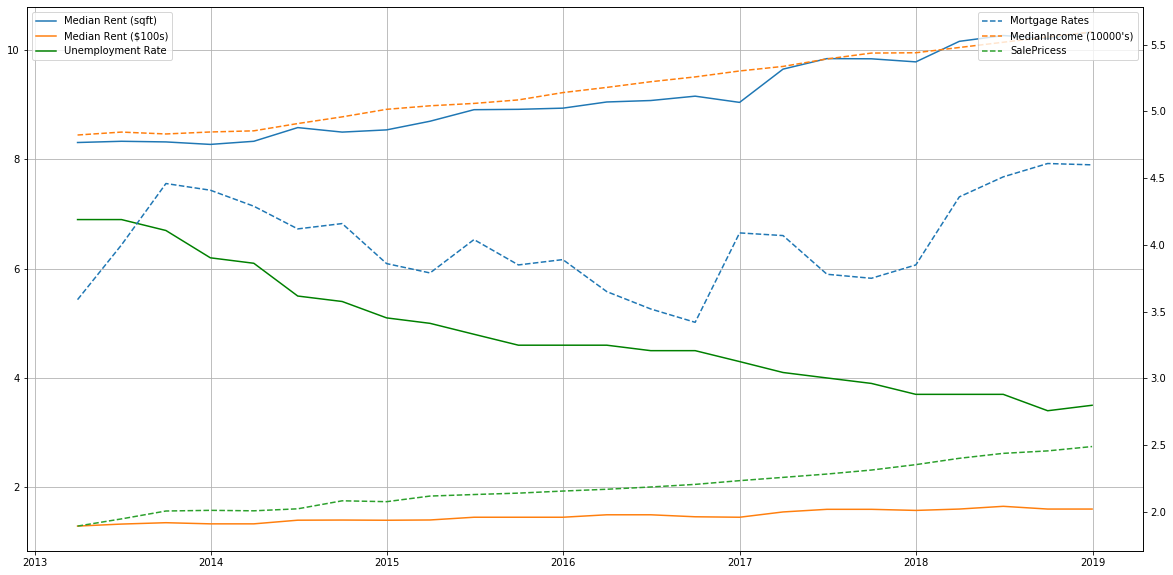

,Year,Month,Quarter,RentalRateSqFt,UnemploymentRate,RentalRate,MortgageRate,Listings,SaleCounts,SalePrices,MedianIncome
Date,,,,,,,,,,,
2013-03-01,2013,3,1,0.831094,6.9,1288.0,3.59,19230.5,2348.0,189300.0,48236.435
2013-06-01,2013,6,2,0.833333,6.9,1325.0,4.00,21615.0,3573.0,194700.0,48455.295
2013-09-01,2013,9,3,0.832169,6.7,1350.0,4.46,21479.5,3028.0,200600.0,48314.185
2013-12-01,2013,12,4,0.827626,6.2,1329.0,4.41,17772.0,2822.0,201100.0,48463.300
2014-03-01,2014,3,1,0.833333,6.1,1329.0,4.29,17909.0,3184.0,200750.0,48549.180


In [347]:
title = 'Rental Rates vs Unemployment by Year'

fig, ax1 = plt.subplots(figsize=(20,10))

df = metrics_yearly.resample('Q').mean().copy()
x_axis = df.index

#OUR HYPOTHSIS METRICS
y_axis = df['RentalRateSqFt']*10
ax1.plot(x_axis,y_axis, label='Median Rent (sqft)', linestyle='solid')

y_axis = df['RentalRate']/1000
ax1.plot(x_axis,y_axis, label='Median Rent ($100s)',linestyle='solid')

ax2 = ax1.twinx()
y_axis = df['UnemploymentRate']
ax1.plot(x_axis,y_axis, label='Unemployment Rate', c='g',linestyle='solid')

#OTHER FACTORS AS POTENTIAL INFLUENCERS
y_axis = df['MortgageRate']
ax2.plot(x_axis,y_axis, label='Mortgage Rates', linestyle='dashed')

y_axis = df['MedianIncome']/10000
ax2.plot(x_axis,y_axis, label=f"MedianIncome (10000's)",linestyle='dashed')

y_axis = df['SalePrices']/100000
ax2.plot(x_axis,y_axis, label='SalePricess', linestyle='dashed')

# Turn on the grid
ax1.grid()
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.xticks(rotation=45)

# Save the Figure
plt.savefig(f"figures\{title.replace(' ','_')}.png")

plt.show()
metrics_yearly.head()

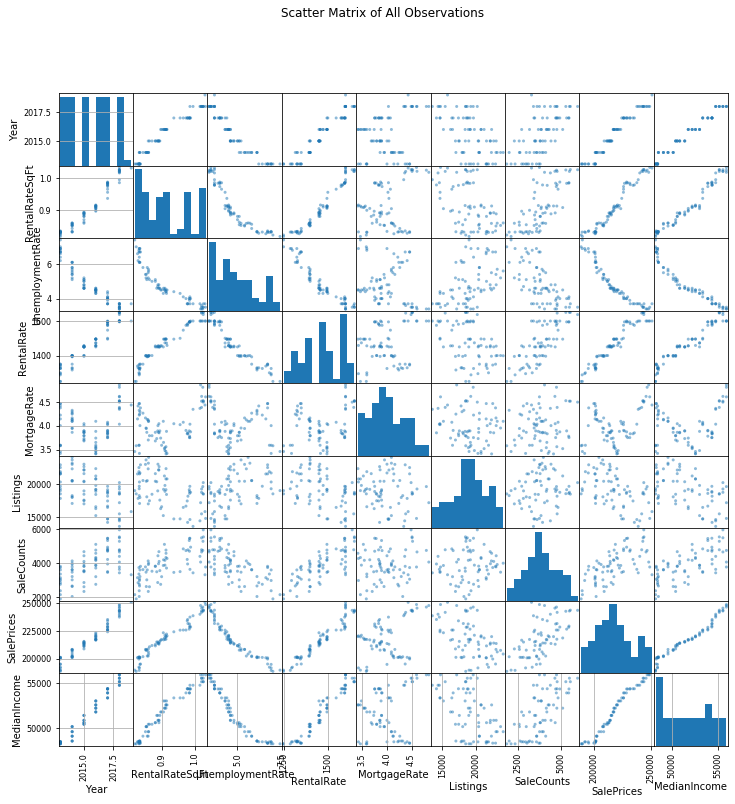

In [458]:
from pandas.plotting import scatter_matrix
title = 'Scatter Matrix of All Observations'

#drop our date column from this scatter_matrix seems useless since it's not historical data
df = metrics_yearly.drop(columns=['Month','Quarter']).copy()

#scatter_matrix(df, figsize=(12,12), grid=True, diagonal='kde', alpha=0.2, color='royalblue')
scatter_matrix(df, figsize=(12,12), grid=True)

plt.suptitle(f'{title}')
#plt.style.use('ggplot')

# Save the Figure
plt.savefig(f"figures\{title.replace(' ','_')}.png")

# Show the Figure
plt.show()

In [349]:
title = 'Mortgage Rates - Monthly BoxPlot'

df = metrics_yearly.unstack(level=0).copy()#.dropna(how='any',axis=1)
#df['MortgageRate'].plot.box(rot=45, grid=True, figsize=(20,10))
metrics_yearly

,Year,Month,Quarter,RentalRateSqFt,UnemploymentRate,RentalRate,MortgageRate,Listings,SaleCounts,SalePrices,MedianIncome
Date,,,,,,,,,,,
2013-03-01,2013,3,1,0.831094,6.9,1288.00,3.59,19230.5,2348.0,189300.0,48236.435000
2013-06-01,2013,6,2,0.833333,6.9,1325.00,4.00,21615.0,3573.0,194700.0,48455.295000
2013-09-01,2013,9,3,0.832169,6.7,1350.00,4.46,21479.5,3028.0,200600.0,48314.185000
2013-12-01,2013,12,4,0.827626,6.2,1329.00,4.41,17772.0,2822.0,201100.0,48463.300000
2014-03-01,2014,3,1,0.833333,6.1,1329.00,4.29,17909.0,3184.0,200750.0,48549.180000
2014-06-01,2014,6,2,0.858411,5.5,1396.00,4.12,22238.0,4103.0,202250.0,49094.680000
2014-09-01,2014,9,3,0.850155,5.4,1398.75,4.16,22909.0,3753.0,208250.0,49595.455000
2014-12-01,2014,12,4,0.854214,5.1,1395.00,3.86,18011.0,2989.0,207600.0,50160.395000
2015-03-01,2015,3,1,0.870064,5.0,1400.00,3.79,18398.0,3497.0,211800.0,50425.570000


In [415]:
import seaborn as sns

# Put dataset on my github repo 
df = pd.read_csv('https://raw.githubusercontent.com/mGalarnyk/Python_Tutorials/master/Kaggle/BreastCancerWisconsin/data/data.csv')
df

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,...,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,...,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,...,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,...,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,...,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,926424,M,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,...,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115,NaN
565,926682,M,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,...,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637,NaN
566,926954,M,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,...,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820,NaN
567,927241,M,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,...,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400,NaN


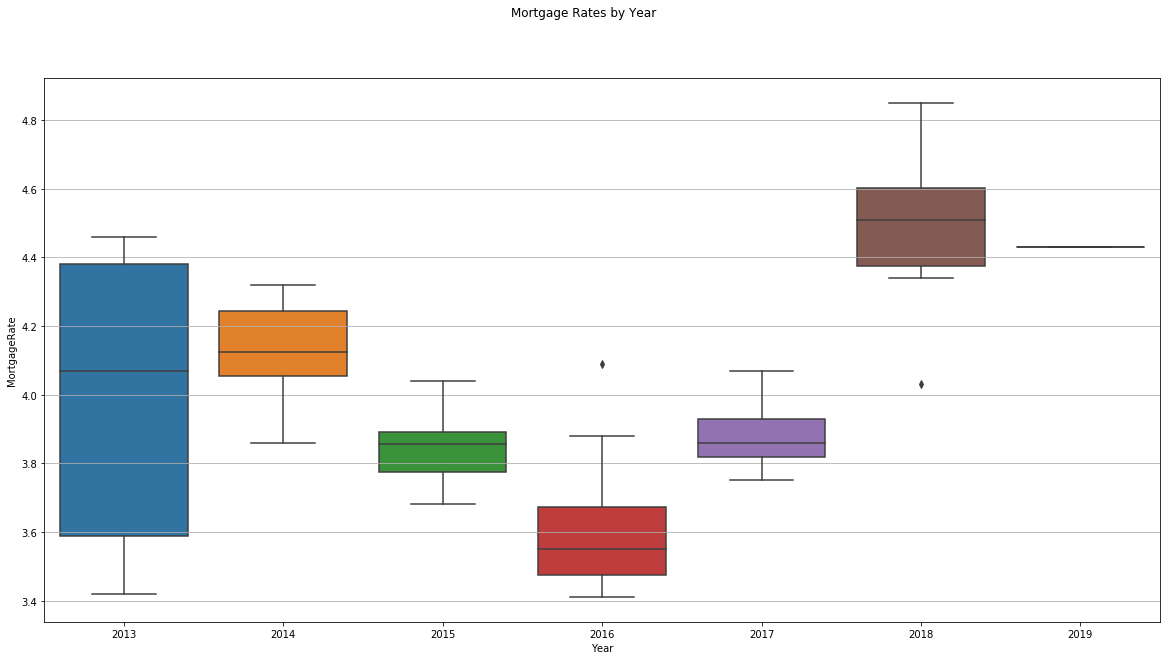

In [457]:
title = 'Mortgage Rates by Year'

plt.figure(figsize=(20,10))

df = metrics_yearly.copy()

sns.boxplot(x=df['Year'],y=df['MortgageRate'],data=df)
sns.set_style({'axes.grid':True})

plt.suptitle(f'{title}')

# Save the Figure
plt.savefig(f"figures\{title.replace(' ','_')}.png")

#plt.show()
#df

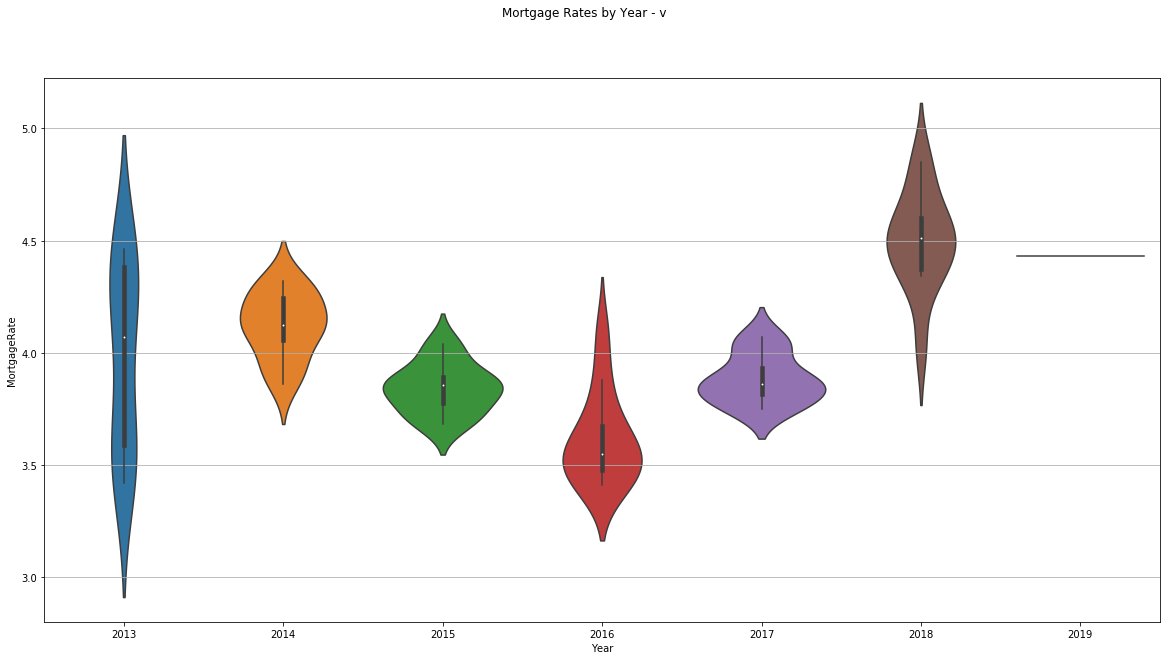

,Year,Month,Quarter,RentalRateSqFt,UnemploymentRate,RentalRate,MortgageRate,Listings,SaleCounts,SalePrices,MedianIncome
Date,,,,,,,,,,,
2013-01-01,2013,1,1,0.817461,7.4,1250.0,3.46,18950.5,2118.0,189500.0,48236.435000
2013-02-01,2013,2,1,0.821955,7.0,1250.0,3.58,18459.0,1870.0,188400.0,48236.435000
2013-03-01,2013,3,1,0.831094,6.9,1288.0,3.59,19230.5,2348.0,189300.0,48236.435000
2013-04-01,2013,4,2,0.831767,6.9,1295.0,3.42,20254.0,2951.0,191500.0,48455.295000
2013-05-01,2013,5,2,0.830218,6.8,1300.0,3.59,21811.0,3331.0,192150.0,48455.295000
...,...,...,...,...,...,...,...,...,...,...,...
2018-09-01,2018,9,3,1.021505,3.4,1600.0,4.61,19195.5,4631.0,245650.0,55581.291288
2018-10-01,2018,10,4,1.025000,3.4,1600.0,4.80,19559.5,4722.0,246600.0,55962.065107
2018-11-01,2018,11,4,1.018330,3.4,1600.0,4.85,17127.0,4036.0,248000.0,55962.065107


In [456]:
title = 'Mortgage Rates by Year - v'

plt.figure(figsize=(20,10))

df = metrics_yearly.copy()

sns.violinplot(x=df['Year'],y=df['MortgageRate'],data=df)
sns.set_style({'axes.grid':True})

plt.suptitle(f'{title}')

# Save the Figure
plt.savefig(f"figures\{title.replace(' ','_')}.png")

plt.show()
df

In [473]:
metrics_yearly.reset_index().filter(items=['Year','MortgageRate']).copy()

,Year,MortgageRate
0,2013,3.46
1,2013,3.58
2,2013,3.59
3,2013,3.42
4,2013,3.59
...,...,...
68,2018,4.61
69,2018,4.80
70,2018,4.85
71,2018,4.60


ValueError: The truth value of a DataFrame is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

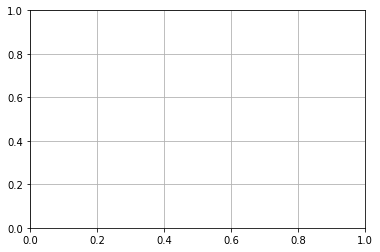

In [499]:
title = 'Rental Rates vs Unemployment by Year'

df = metrics_yearly.reset_index().filter(items=['Year','MortgageRate','RentalRateSqFt']).copy()
#df = metrics_yearly.resample('Q').mean().copy()
x_axis = df['Year'].unique()

plt.boxplot(df.groupby('Year'))

y_axis = df['RentalRateSqFt']*10
plt.plot(x_axis,y_axis)

#plt.legend(loc='best')
plt.show()
df

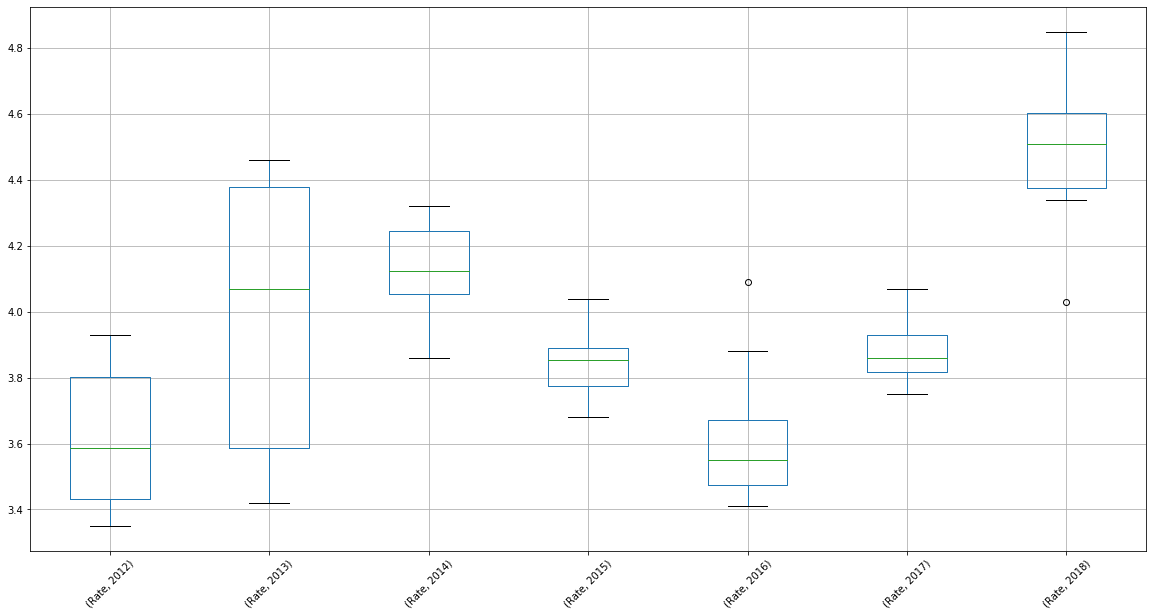

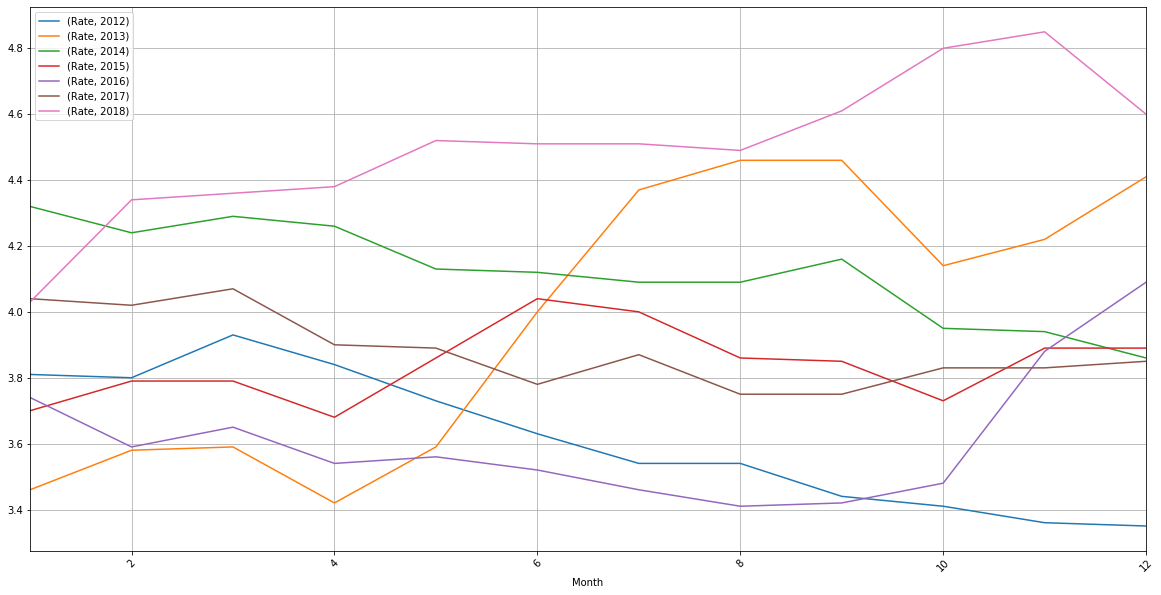

Rate                                    
Year   2012  2013  2014  2015  2016  2017  2018
Month                                          
1      3.81  3.46  4.32  3.70  3.74  4.04  4.03
2      3.80  3.58  4.24  3.79  3.59  4.02  4.34
3      3.93  3.59  4.29  3.79  3.65  4.07  4.36
4      3.84  3.42  4.26  3.68  3.54  3.90  4.38
5      3.73  3.59  4.13  3.86  3.56  3.89  4.52

In [319]:
mortgage_rates_monthly = mortgage_rates_src.copy()
mortgage_rates_monthly = mortgage_rates_monthly.drop(columns='TimePeriod')
mortgage_rates_monthly = mortgage_rates_monthly.rename(columns={'MortgageRateConventionalFixed':'Rate'})
mortgage_rates_monthly['Date'] = pd.to_datetime(mortgage_rates_monthly['Date'], format='%Y-%m-%d')
mortgage_rates_monthly['Year'] = pd.DatetimeIndex(mortgage_rates_monthly['Date']).year
mortgage_rates_monthly['Month'] = pd.DatetimeIndex(mortgage_rates_monthly['Date']).month
mortgage_rates_monthly = mortgage_rates_monthly.drop(columns='Date')
mortgage_rates_monthly = mortgage_rates_monthly[['Year','Month','Rate']]
mortgage_rates_monthly = mortgage_rates_monthly.groupby(['Year','Month']).median()
mortgage_rates_monthly = mortgage_rates_monthly.unstack(level=0).dropna(how='any',axis=1)
#Let's thorw up a quick plot to see change over time by Size / period

title = 'Mortgage Rates - Monthly BoxPlot'
mortgage_rates_monthly.plot.box(rot=45, grid=True, figsize=(20,10))
plt.savefig(f'figures\{title}.png')


plt.show()


mortgage_rates_monthly.head()

In [ ]:
title = 'Scatter Matrix of All Observations - SNS'

plt.figure(figsize=(18,18))

sns.set_style("whitegrid")
sns.set_style({'axes.grid':True})

df = metrics_yearly.drop(columns=['Month','Quarter'])

sns.pairplot(df)

plt.suptitle(f'{title}')
# Save the Figure
plt.savefig(f"figures\{title.replace(' ','_')}.png")

# Show the Figure
plt.show()

In [500]:
metrics_yearly

,Year,Month,Quarter,RentalRateSqFt,UnemploymentRate,RentalRate,MortgageRate,Listings,SaleCounts,SalePrices,MedianIncome
Date,,,,,,,,,,,
2013-01-01,2013,1,1,0.817461,7.4,1250.0,3.46,18950.5,2118.0,189500.0,48236.435000
2013-02-01,2013,2,1,0.821955,7.0,1250.0,3.58,18459.0,1870.0,188400.0,48236.435000
2013-03-01,2013,3,1,0.831094,6.9,1288.0,3.59,19230.5,2348.0,189300.0,48236.435000
2013-04-01,2013,4,2,0.831767,6.9,1295.0,3.42,20254.0,2951.0,191500.0,48455.295000
2013-05-01,2013,5,2,0.830218,6.8,1300.0,3.59,21811.0,3331.0,192150.0,48455.295000
...,...,...,...,...,...,...,...,...,...,...,...
2018-09-01,2018,9,3,1.021505,3.4,1600.0,4.61,19195.5,4631.0,245650.0,55581.291288
2018-10-01,2018,10,4,1.025000,3.4,1600.0,4.80,19559.5,4722.0,246600.0,55962.065107
2018-11-01,2018,11,4,1.018330,3.4,1600.0,4.85,17127.0,4036.0,248000.0,55962.065107


In [516]:
metrics_yearly_anova = metrics_yearly.filter(items=['RentalRateSqFt','UnemploymentRate'].copy()

SyntaxError: unexpected EOF while parsing (<ipython-input-516-de8ee6d8e6de>, line 1)

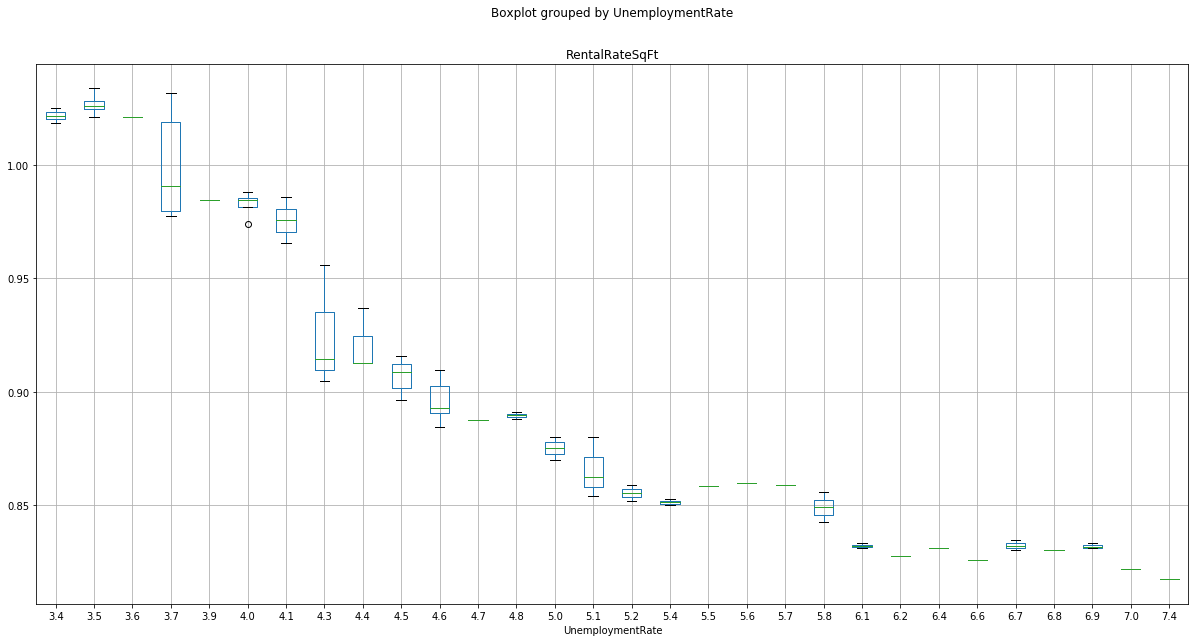

In [532]:
metrics_yearly_anova = metrics_yearly.filter(items=['RentalRateSqFt','UnemploymentRate']).copy()
metrics_yearly_anova.boxplot("RentalRateSqFt", by="UnemploymentRate", figsize=(20, 10))

In [552]:
groups = metrics_yearly_anova['UnemploymentRate'].unique()
groups

array([7.4, 7. , 6.9, 6.8, 6.7, 6.6, 6.4, 6.2, 6.1, 5.8, 5.5, 5.6, 5.7,
       5.4, 5.2, 5.1, 5. , 4.8, 4.6, 4.7, 4.5, 4.4, 4.3, 4.1, 4. , 3.9,
       3.7, 3.6, 3.5, 3.4])

In [525]:
group1 = metrics_yearly_anova[metrics_yearly_anova["UnemploymentRate"] == 7.4]["RentalRateSqFt"]
group2 = metrics_yearly_anova[metrics_yearly_anova["UnemploymentRate"] == 7.]["RentalRateSqFt"]
group3 = metrics_yearly_anova[metrics_yearly_anova["UnemploymentRate"] == 6.9]["RentalRateSqFt"]
group4 = metrics_yearly_anova[metrics_yearly_anova["UnemploymentRate"] == 6.8]["RentalRateSqFt"]
group5 = metrics_yearly_anova[metrics_yearly_anova["UnemploymentRate"] == 6.7]["RentalRateSqFt"]
group6 = metrics_yearly_anova[metrics_yearly_anova["UnemploymentRate"] == 6.6]["RentalRateSqFt"]
group7 = metrics_yearly_anova[metrics_yearly_anova["UnemploymentRate"] == 6.4]["RentalRateSqFt"]
group8 = metrics_yearly_anova[metrics_yearly_anova["UnemploymentRate"] == 6.2]["RentalRateSqFt"]
group9 = metrics_yearly_anova[metrics_yearly_anova["UnemploymentRate"] == 6.1]["RentalRateSqFt"]
group10 = metrics_yearly_anova[metrics_yearly_anova["UnemploymentRate"] == 5.8]["RentalRateSqFt"]
group11 = metrics_yearly_anova[metrics_yearly_anova["UnemploymentRate"] == 5.5]["RentalRateSqFt"]
group12 = metrics_yearly_anova[metrics_yearly_anova["UnemploymentRate"] == 5.6]["RentalRateSqFt"]
group13 = metrics_yearly_anova[metrics_yearly_anova["UnemploymentRate"] == 5.7]["RentalRateSqFt"]
group14 = metrics_yearly_anova[metrics_yearly_anova["UnemploymentRate"] == 5.4]["RentalRateSqFt"]
group15 = metrics_yearly_anova[metrics_yearly_anova["UnemploymentRate"] == 5.2]["RentalRateSqFt"]
group16 = metrics_yearly_anova[metrics_yearly_anova["UnemploymentRate"] == 5.1]["RentalRateSqFt"]
group17 = metrics_yearly_anova[metrics_yearly_anova["UnemploymentRate"] == 5.]["RentalRateSqFt"]
group18 = metrics_yearly_anova[metrics_yearly_anova["UnemploymentRate"] == 4.8]["RentalRateSqFt"]
group19 = metrics_yearly_anova[metrics_yearly_anova["UnemploymentRate"] == 4.6]["RentalRateSqFt"]
group20 = metrics_yearly_anova[metrics_yearly_anova["UnemploymentRate"] == 4.7]["RentalRateSqFt"]
group21 = metrics_yearly_anova[metrics_yearly_anova["UnemploymentRate"] == 4.5]["RentalRateSqFt"]
group22 = metrics_yearly_anova[metrics_yearly_anova["UnemploymentRate"] == 4.4]["RentalRateSqFt"]
group23 = metrics_yearly_anova[metrics_yearly_anova["UnemploymentRate"] == 4.3]["RentalRateSqFt"]
group24 = metrics_yearly_anova[metrics_yearly_anova["UnemploymentRate"] == 4.1]["RentalRateSqFt"]
group25 = metrics_yearly_anova[metrics_yearly_anova["UnemploymentRate"] == 4.]["RentalRateSqFt"]
group26 = metrics_yearly_anova[metrics_yearly_anova["UnemploymentRate"] == 3.9]["RentalRateSqFt"]
group27 = metrics_yearly_anova[metrics_yearly_anova["UnemploymentRate"] == 3.7]["RentalRateSqFt"]
group28 = metrics_yearly_anova[metrics_yearly_anova["UnemploymentRate"] == 3.6]["RentalRateSqFt"]
group29 = metrics_yearly_anova[metrics_yearly_anova["UnemploymentRate"] == 3.5]["RentalRateSqFt"]
group30 = metrics_yearly_anova[metrics_yearly_anova["UnemploymentRate"] == 3.4]["RentalRateSqFt"]

In [527]:
import scipy.stats as stats
stats.f_oneway(group1,group2,group3,group4,group5,group6,group7,group8,group9,group10,group11,group12,group13,group14,group15,group16,group17,group18,group19,group20,group21,group22,group23,group24,group25,group26,group27,group28,group29,group30)

F_onewayResult(statistic=70.375758529209, pvalue=8.330711145984531e-28)

In [553]:
stats.f_oneway(*[metrics_yearly_anova[metrics_yearly_anova["UnemploymentRate"] == grp]["RentalRateSqFt"] for grp in groups])

F_onewayResult(statistic=70.375758529209, pvalue=8.330711145984531e-28)

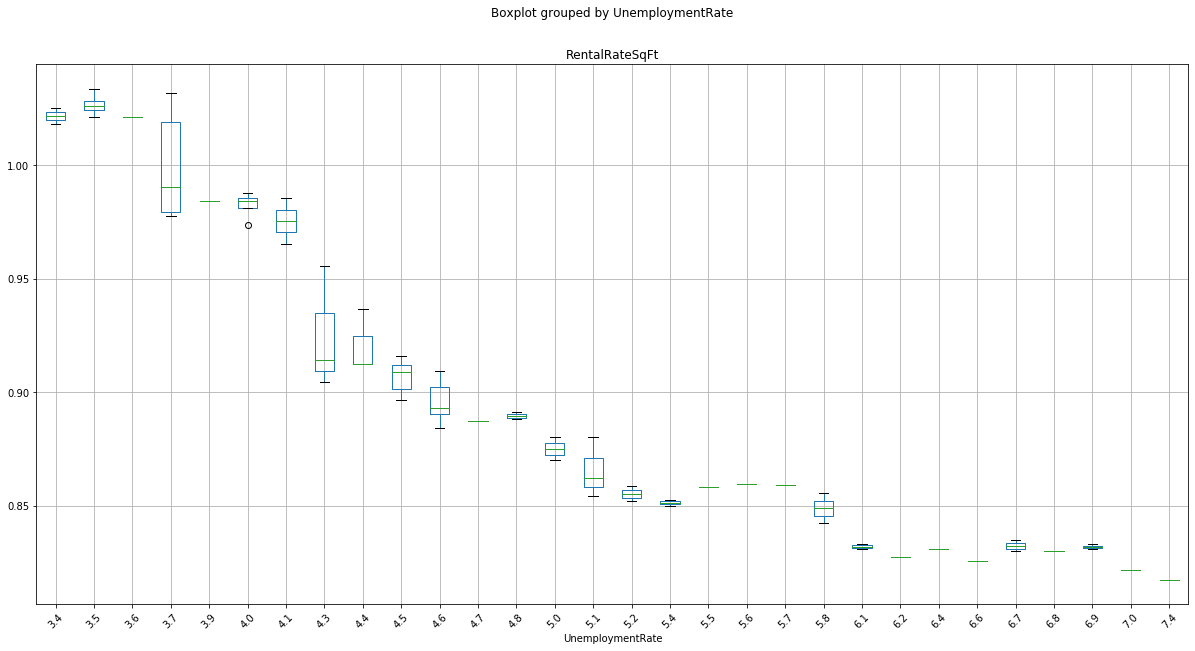

In [573]:
metrics_yearly_anova_emp = metrics_yearly.filter(items=['RentalRateSqFt','UnemploymentRate']).copy()
metrics_yearly_anova_emp = metrics_yearly_anova_emp.dropna()
metrics_yearly_anova_emp['UnemploymentRate'] = metrics_yearly_anova_emp['UnemploymentRate'].round(decimals=2)
metrics_yearly_anova_emp.boxplot("RentalRateSqFt", by="UnemploymentRate", figsize=(20, 10), rot=45)

In [ ]:
groups = metrics_yearly_anova_emp['UnemploymentRate'].unique()
groups

In [553]:
stats.f_oneway(*[metrics_yearly_anova[metrics_yearly_anova["UnemploymentRate"] == grp]["RentalRateSqFt"] for grp in groups])

F_onewayResult(statistic=70.375758529209, pvalue=8.330711145984531e-28)

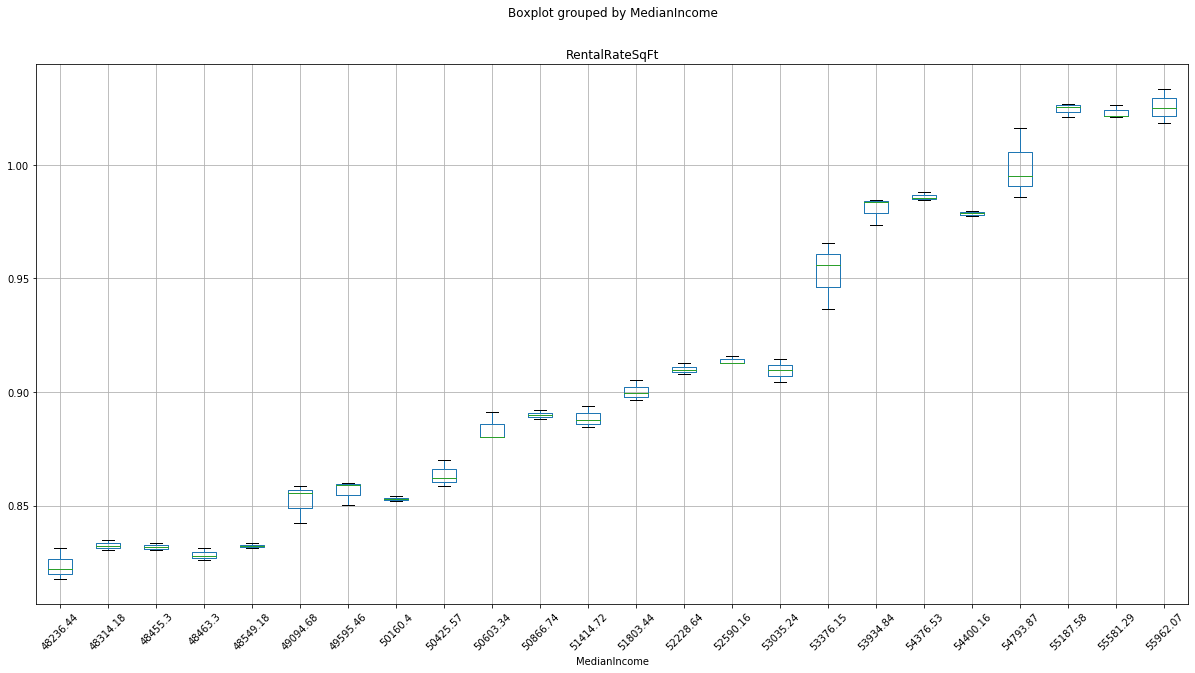

In [572]:
metrics_yearly_anova_inc = metrics_yearly.filter(items=['RentalRateSqFt','MedianIncome']).copy()
metrics_yearly_anova_inc = metrics_yearly_anova_inc.dropna()
metrics_yearly_anova_inc['MedianIncome'] = metrics_yearly_anova_inc['MedianIncome'].round(decimals=2)
metrics_yearly_anova_inc.boxplot("RentalRateSqFt", by="MedianIncome", figsize=(20, 10), rot=45)

In [575]:
groups = metrics_yearly_anova_inc['MedianIncome'].unique()
groups

array([48236.44, 48455.3 , 48314.18, 48463.3 , 48549.18, 49094.68,
       49595.46, 50160.4 , 50425.57, 50603.34, 50866.74, 51414.72,
       51803.44, 52228.64, 52590.16, 53035.24, 53376.15, 53934.84,
       54376.53, 54400.16, 54793.87, 55187.58, 55581.29, 55962.07])

In [576]:
stats.f_oneway(*[metrics_yearly_anova_inc[metrics_yearly_anova_inc["MedianIncome"] == grp]["RentalRateSqFt"] for grp in groups])

F_onewayResult(statistic=384.5884229347032, pvalue=8.331698465058281e-47)

In [582]:
affordability_index.stack().stack().unstack(level=0)

Index                                                       Mortgage Affordability  \
State City      RegionID RegionName    SizeRank Month Year                           
 AK   Anchorage 394327   Anchorage, AK 133      03    1979                0.248123   
                                                      1980                     NaN   
                                                      1981                     NaN   
                                                      1982                0.425953   
                                                      1983                0.300196   
...                                                                            ...   
 WY   Cheyenne  394462   Cheyenne, WY  405      12    2014                0.149774   
                                                      2015                0.159884   
                                                      2016                0.168088   
                                                      2017                0.167941   
                                                      2018                0.194804   

Index                                                       Price To Income  \
State City      RegionID RegionName    SizeRank Month Year                    
 AK   Anchorage 394327   Anchorage, AK 133      03    1979         2.841764   
                                                      1980              NaN   
                                                      1981              NaN   
                                                      1982         3.084107   
                                                      1983         2.867294   
...                                                                     ...   
 WY   Cheyenne  394462   Cheyenne, WY  405      12    2014         3.323856   
                                                      2015         3.505393   
                                                      2016         3.580477   
                                                      2017         3.686512   
                                                      2018         3.939926   

Index                                                       Rent Affordability  
State City      RegionID RegionName    SizeRank Month Year                      
 AK   Anchorage 394327   Anchorage, AK 133      03    1979            0.275237  
                                                      1980            0.264324  
                                                      1981            0.241435  
                                                      1982            0.232009  
                                                      1983            0.218605  
...                                                                        ...  
 WY   Cheyenne  394462   Cheyenne, WY  405      12    2014                 NaN  
                                                      2015                 NaN  
                                                      2016                 NaN  
                                                      2017                 NaN  
                                                      2018                 NaN  

[57500 rows x 3 columns]

In [623]:
affordability_index = affordability_index_src.copy()
affordability_index['State'] = affordability_index["RegionName"].apply(lambda x: "".join(x.split(',')[1:]))
affordability_index['City'] = affordability_index["RegionName"].apply(lambda x: "".join(x.split(',')[0]))
affordability_index_us = affordability_index.query('City == "United States"')
affordability_index = affordability_index[~affordability_index['City'].str.contains("United States")]
affordability_index = affordability_index.drop(columns=['City','RegionID','RegionName','SizeRank','HistoricAverage_1985thru1999'])
affordability_index = affordability_index.set_index(['Index','State'])
#affordability_index.set_index(['Index','State','City','RegionID','RegionName','SizeRank'],inplace=True)
affordability_index.columns = pd.MultiIndex.from_tuples([tuple(c.split('-'))for c in affordability_index.columns],names=['Year','Month'])
affordability_index
#affordability_index = pd.DataFrame(affordability_index.median()).reset_index()
#affordability_index = affordability_index#.stack(level=1)
#affordability_index.reset_index().columns
#affordability_index.stack().stack().unstack(level=0)
affordability_index = pd.DataFrame(affordability_index.stack().stack()).reset_index()
#affordability_index.columns=['Year','Month',affordability_index]
df = affordability_index
df

,Index,State,Month,Year,0
0,Price To Income,NY,03,1979,2.928344
1,Price To Income,NY,03,1980,3.007144
2,Price To Income,NY,03,1981,3.018619
3,Price To Income,NY,03,1982,2.917857
4,Price To Income,NY,03,1983,2.995379
...,...,...,...,...,...
150357,Rent Affordability,NV,12,2014,0.314937
150358,Rent Affordability,NV,12,2015,0.306936
150359,Rent Affordability,NV,12,2016,0.313584
150360,Rent Affordability,NV,12,2017,0.313955


In [584]:

# quick chart
affordability_index.query("Index == 'Price To Income'").median().plot(rot=45, grid=True, label='pti')
affordability_index.query("Index == 'Mortgage Affordability'").median().plot(rot=45, grid=True, label='mga')
affordability_index.query("Index == 'Rent Affordability'").median().plot(rot=45, grid=True, label='rta', figsize=(20,10))

plt.legend(loc='best')
plt.show()

affordability_index.head()

C:\Users\rmr\AppData\Local\Continuum\anaconda3\envs\class\lib\site-packages\pandas\core\generic.py:3946: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_axis = axis.drop(labels, errors=errors)


UndefinedVariableError: name 'Index' is not defined